In [114]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense, Flatten, TextVectorization, Attention
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision, layers, metrics, backend as K, regularizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve
mixed_precision.set_global_policy('mixed_float16')

In [115]:
# load datasets
test_df = pd.read_parquet("test_dataset_ebnerd_small.parquet")
train_df = pd.read_parquet("train_dataset_ebnerd_small.parquet")
val_df = pd.read_parquet("val_dataset_ebnerd_small.parquet")

In [116]:
test_df.head()

,impression_id,session_id,user_id,article_id,clicked,user_average_read_time,user_average_scroll_percentage,user_impression_frequency,user_interaction_score,user_mood,...,origin_current_diff_impression_published,time_of_day,origin_cluster,origin_current_same_cluster,origin_current_same_category,origin_current_same_sentiment_label,origin_current_diff_sentiment_score,user_article_same_mood,user_article_favorite,user_article_least_favorite
0,149474,759,139836,9778623,False,21.0,52.823529,52962.0,36.911765,Negative,...,0.0,Morning,2.0,False,False,False,-0.4893,True,False,True
1,149474,759,139836,9778682,False,21.0,52.823529,52962.0,36.911765,Negative,...,0.0,Morning,2.0,False,False,False,-0.4546,True,False,False
2,149474,759,139836,9778669,False,21.0,52.823529,52962.0,36.911765,Negative,...,0.0,Morning,2.0,False,False,False,-0.4481,True,True,False
3,149474,759,139836,9778657,True,21.0,52.823529,52962.0,36.911765,Negative,...,0.0,Morning,2.0,False,False,True,-0.3347,False,True,False
4,149474,759,139836,9778736,False,21.0,52.823529,52962.0,36.911765,Negative,...,0.0,Morning,2.0,False,False,False,-0.2485,False,False,False


In [117]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882518 entries, 0 to 1882517
Data columns (total 33 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   impression_id                             uint32 
 1   session_id                                uint32 
 2   user_id                                   uint32 
 3   article_id                                int32  
 4   clicked                                   bool   
 5   user_average_read_time                    float64
 6   user_average_scroll_percentage            float64
 7   user_impression_frequency                 float64
 8   user_interaction_score                    float64
 9   user_mood                                 object 
 10  premium                                   bool   
 11  sentiment_score                           float32
 12  sentiment_label                           object 
 13  cluster                                   int32  
 14  de

In [118]:
train_df.head()

,impression_id,session_id,user_id,article_id,clicked,user_average_read_time,user_average_scroll_percentage,user_impression_frequency,user_interaction_score,user_mood,...,origin_current_diff_impression_published,time_of_day,origin_cluster,origin_current_same_cluster,origin_current_same_category,origin_current_same_sentiment_label,origin_current_diff_sentiment_score,user_article_same_mood,user_article_favorite,user_article_least_favorite
0,157014,4180,526520,9743870,False,26.844961,70.83871,12914.0,48.841835,Negative,...,2700.0,Evening,0.0,True,True,True,0.0490,True,False,False
1,157014,4180,526520,9776386,False,26.844961,70.83871,12914.0,48.841835,Negative,...,2700.0,Evening,0.0,True,False,False,0.0278,False,False,False
2,157014,4180,526520,9776394,False,26.844961,70.83871,12914.0,48.841835,Negative,...,2700.0,Evening,0.0,True,False,True,0.0570,True,False,False
3,157014,4180,526520,9776438,False,26.844961,70.83871,12914.0,48.841835,Negative,...,2700.0,Evening,0.0,True,False,False,0.1626,False,True,False
4,157014,4180,526520,9776442,True,26.844961,70.83871,12914.0,48.841835,Negative,...,2700.0,Evening,0.0,True,False,True,0.0870,True,False,False


In [119]:
val_df.head()

,impression_id,session_id,user_id,article_id,clicked,user_average_read_time,user_average_scroll_percentage,user_impression_frequency,user_interaction_score,user_mood,...,origin_current_diff_impression_published,time_of_day,origin_cluster,origin_current_same_cluster,origin_current_same_category,origin_current_same_sentiment_label,origin_current_diff_sentiment_score,user_article_same_mood,user_article_favorite,user_article_least_favorite
0,753820,37834,1651200,9771156,False,85.076923,67.666667,31113.0,76.371795,Negative,...,47152.0,Night,0.0,True,False,True,-0.0076,False,True,False
1,753820,37834,1651200,9778351,False,85.076923,67.666667,31113.0,76.371795,Negative,...,47152.0,Night,0.0,True,False,True,0.0655,False,True,False
2,753820,37834,1651200,9774527,False,85.076923,67.666667,31113.0,76.371795,Negative,...,47152.0,Night,0.0,True,False,True,0.0029,False,True,False
3,753820,37834,1651200,9777492,False,85.076923,67.666667,31113.0,76.371795,Negative,...,47152.0,Night,0.0,True,False,False,-0.0428,True,True,False
4,753820,37834,1651200,9777856,False,85.076923,67.666667,31113.0,76.371795,Negative,...,47152.0,Night,0.0,True,False,True,0.2966,False,False,False


In [120]:
print(f"Train set size: {len(train_df)} samples")
print(f"Test set size: {len(test_df)} samples")
print(f"Validation set size: {len(val_df)} samples")

Train set size: 1882518 samples
Test set size: 359446 samples
Validation set size: 343776 samples


In [121]:
# data preparation
target = ["clicked"]
ids = ["impression_id", "session_id", "article_id", "user_id"]
excluded_columns = target + ids

categorical_columns = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
boolean_columns = train_df.select_dtypes(include=['bool']).columns.tolist()
boolean_columns = [col for col in boolean_columns if col not in excluded_columns]
numerical_columns = [col for col in train_df.columns if col not in excluded_columns + categorical_columns + boolean_columns]

feature_list = list(set(categorical_columns + boolean_columns + numerical_columns))

print("Features used for modeling:", feature_list)

Features used for modeling: ['coming_from_home_page', 'origin_cluster', 'user_article_least_favorite', 'sentiment_label', 'cluster', 'origin_current_diff_published', 'sentiment_score', 'time_of_day', 'device_type', 'user_article_favorite', 'origin_current_same_cluster', 'is_subscriber', 'user_average_read_time', 'user_interaction_score', 'origin_current_diff_sentiment_score', 'origin_scroll_percentage', 'origin_current_diff_impression_published', 'origin_current_same_category', 'is_sso_user', 'user_average_scroll_percentage', 'premium', 'origin_sentiment_label', 'origin_current_same_sentiment_label', 'origin_read_time', 'user_article_same_mood', 'user_mood', 'origin_sentiment_score', 'user_impression_frequency']


In [122]:
# encoding categorical columns
for col in categorical_columns:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    val_df[col] = le.transform(val_df[col])
    test_df[col] = le.transform(test_df[col])

In [123]:
# normalize numerical features
scaler = StandardScaler()
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
val_df[numerical_columns] = scaler.transform(val_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

In [124]:
# define model inputs
categorical_input = layers.Input(shape=(len(categorical_columns),), name="categorical_input")
numerical_input = layers.Input(shape=(len(numerical_columns),), name="numerical_input")
boolean_input = layers.Input(shape=(len(boolean_columns),), name="boolean_input")

In [125]:
# embedding layers for categorical inputs
embedding_dim = 16
embedded_categorical = layers.Embedding(
    input_dim=train_df[categorical_columns].max().max() + 1, output_dim=embedding_dim
)(categorical_input)
flattened_categorical = layers.Flatten()(embedded_categorical)

In [126]:
# dense layers for numerical inputs
numerical_dense = layers.Dense(32, activation='relu')(numerical_input)

In [127]:
# dense layers for boolean inputs (treated as numerical)
boolean_dense = layers.Dense(16, activation='relu')(boolean_input)

In [128]:
# concatenate all features
concatenated = layers.Concatenate()([flattened_categorical, numerical_dense, boolean_dense])

x = layers.Dense(64, activation='relu')(concatenated)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

In [130]:
# define the model
model = Model(inputs=[categorical_input, numerical_input, boolean_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.AUC(), metrics.Precision(), metrics.Recall()])
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ categorical_input         │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 4, 16)          │             64 │ categorical_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numerical_input           │ (None, 14)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ boolean_input             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 64)             │              0 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (None, 32)             │            480 │ numerical_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_41 (Dense)          │ (None, 16)             │            176 │ boolean_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 112)            │              0 │ flatten_4[0][0],       │
│ (Concatenate)             │                        │                │ dense_40[0][0],        │
│                           │                        │                │ dense_41[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_42 (Dense)          │ (None, 64)             │          7,232 │ concatenate_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 64)             │              0 │ dense_42[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_43 (Dense)          │ (None, 32)             │          2,080 │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_44 (Dense)          │ (None, 1)              │             33 │ dense_43[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,065 (39.32 KB)

 Trainable params: 10,065 (39.32 KB)

 Non-trainable params: 0 (0.00 B)

In [131]:
# prepare training data
X_train = [
    train_df[categorical_columns].values,
    train_df[numerical_columns].values,
    train_df[boolean_columns].values
]
y_train = train_df['clicked'].values

# prepare validation data
X_val = [
    val_df[categorical_columns].values,
    val_df[numerical_columns].values,
    val_df[boolean_columns].values
]
y_val = val_df['clicked'].values

# prepare test data
X_test = [
    test_df[categorical_columns].values,
    test_df[numerical_columns].values,
    test_df[boolean_columns].values
]
y_test = test_df['clicked'].values

In [132]:
# fine tuning
# calculate class weights to balance the dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [133]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc_9',
    patience=5,
    restore_best_weights=True,
    mode='max'
)

# train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
29415/29415 ━━━━━━━━━━━━━━━━━━━━ 75s 2ms/step - auc_9: 0.6597 - loss: nan - precision_9: 0.1297 - recall_9: 0.6730 - val_auc_9: 0.6765 - val_loss: 0.6403 - val_precision_9: 0.1387 - val_recall_9: 0.6881
Epoch 2/20
29415/29415 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - auc_9: 0.6844 - loss: nan - precision_9: 0.1356 - recall_9: 0.7074 - val_auc_9: 0.6678 - val_loss: 0.5775 - val_precision_9: 0.1475 - val_recall_9: 0.5557
Epoch 3/20
29415/29415 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - auc_9: 0.6878 - loss: nan - precision_9: 0.1368 - recall_9: 0.7055 - val_auc_9: 0.6750 - val_loss: 0.6204 - val_precision_9: 0.1403 - val_recall_9: 0.6681
Epoch 4/20
29415/29415 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - auc_9: 0.6894 - loss: nan - precision_9: 0.1376 - recall_9: 0.7020 - val_auc_9: 0.6784 - val_loss: 0.6063 - val_precision_9: 0.1450 - val_recall_9: 0.6297
Epoch 5/20
29415/29415 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - auc_9: 0.6907 - loss: nan - precision_9: 0.1381 - recall_9: 0.7013 - val_auc_9: 0.680

In [134]:
# evaluate the model
results = model.evaluate(X_test, y_test, verbose=1)
print(f"Test AUC: {results[1]:.4f}")

11233/11233 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - auc_9: 0.6869 - loss: nan - precision_9: 0.1452 - recall_9: 0.6285
Test AUC: 0.6866


In [135]:
# predict on the test set
test_predictions = model.predict(X_test).flatten()
test_df['predicted_score'] = test_predictions

11233/11233 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step


In [136]:
test_df['predicted_score'] = test_df['predicted_score'].astype('float32')
test_data = test_df.sort_values(by=['impression_id', 'predicted_score'], ascending=[True, False])
print(test_df[['impression_id', 'user_id', 'article_id','clicked', 'predicted_score']])

        impression_id  user_id  article_id  clicked  predicted_score
0              149474   139836     9778623    False         0.485840
1              149474   139836     9778682    False         0.524902
2              149474   139836     9778669    False         0.606445
3              149474   139836     9778657     True         0.616211
4              149474   139836     9778736    False         0.558594
...               ...      ...         ...      ...              ...
359441      579756177   434871     9778827     True         0.549316
359442      579756177   434871     9777397    False         0.529785
359443      579756177   434871     9778219    False         0.539062
359444      579756177   434871     9778842    False         0.560059
359445      579756177   434871     9778843    False         0.601074

[359446 rows x 5 columns]


In [137]:
test_df = test_df.dropna(subset=['clicked', 'predicted_score'])

In [138]:
#metrics
# AUC Calculation
def calculate_auc(data):
    """Calculate AUC for a given dataset."""
    if data['clicked'].nunique() < 2:
        return np.nan
    try:
        return roc_auc_score(data['clicked'], data['predicted_score'])
    except ValueError:
        return np.nan

# MRR Calculation
def calculate_mrr(data):
    """Calculate MRR for a given dataset."""
    sorted_data = data.sort_values(by='predicted_score', ascending=False)
    ranks = sorted_data['clicked'].values
    for rank, interaction in enumerate(ranks, start=1):
        if interaction == 1:
            return 1 / rank
    return 0

# NDCG Calculation
def dcg(scores, k):
    """Calculate Discounted Cumulative Gain."""
    return sum([score / np.log2(idx + 2) for idx, score in enumerate(scores[:k])])

def calculate_ndcg(data, k):
    """Calculate NDCG for a given dataset and cutoff k."""
    sorted_data = data.sort_values(by='predicted_score', ascending=False)
    ideal_sorted_data = data.sort_values(by='clicked', ascending=False)
    dcg_k = dcg(sorted_data['clicked'].values, k)
    idcg_k = dcg(ideal_sorted_data['clicked'].values, k)
    return dcg_k / idcg_k if idcg_k > 0 else 0


In [139]:
def evaluate_by_impression(test_data):
    """Evaluate the model using AUC, MRR, and NDCG metrics."""
    results = []
    grouped = test_data.groupby('impression_id')

    for impression_id, group in grouped:
        auc = calculate_auc(group)
        mrr = calculate_mrr(group)
        ndcg3 = calculate_ndcg(group, 3)
        ndcg5 = calculate_ndcg(group, 5)
        ndcg10 = calculate_ndcg(group, 10)

        # Append the result as a dictionary
        results.append({
            'impression_id': impression_id,
            'AUC': auc,
            'MRR': mrr,
            'NDCG@3': ndcg3,
            'NDCG@5': ndcg5,
            'NDCG@10': ndcg10
        })

    results_df = pd.DataFrame(results)
    return results_df.dropna()

# Evaluate the model
results = evaluate_by_impression(test_df)
print(results)

       impression_id       AUC       MRR   NDCG@3    NDCG@5   NDCG@10
0             149474  1.000000  1.000000  1.00000  1.000000  1.000000
1             150528  0.250000  0.142857  0.00000  0.000000  0.333333
2             153068  0.833333  0.500000  0.63093  0.630930  0.630930
3             153070  0.714286  0.333333  0.50000  0.500000  0.500000
4             153071  1.000000  1.000000  1.00000  1.000000  1.000000
...              ...       ...       ...      ...       ...       ...
32552      579752481  0.400000  0.250000  0.00000  0.430677  0.430677
32553      579752593  1.000000  1.000000  1.00000  1.000000  1.000000
32554      579755467  0.818182  0.333333  0.50000  0.500000  0.500000
32555      579755468  0.285714  0.166667  0.00000  0.000000  0.356207
32556      579756177  0.714286  0.333333  0.50000  0.500000  0.500000

[32557 rows x 6 columns]


In [140]:
# Calculate mean metrics
mean_metrics = {
      'Mean AUC': results['AUC'].mean(),
      'Mean MRR': results['MRR'].mean(),
      'Mean NDCG@3': results['NDCG@3'].mean(),
      'Mean NDCG@5': results['NDCG@5'].mean(),
      'Mean NDCG@10': results['NDCG@10'].mean()
}

print("Mean Metrics:")
for metric, value in mean_metrics.items():
    print(f"{metric}: {value:.4f}")

Mean Metrics:
Mean AUC: 0.6247
Mean MRR: 0.4065
Mean NDCG@3: 0.3669
Mean NDCG@5: 0.4562
Mean NDCG@10: 0.5220


In [141]:
for k in [3, 5, 10]:
    unique_values = results[f'NDCG@{k}'].nunique()
    print(f"Unique NDCG@{k} scores: {unique_values}")

Unique NDCG@3 scores: 4
Unique NDCG@5 scores: 6
Unique NDCG@10 scores: 11


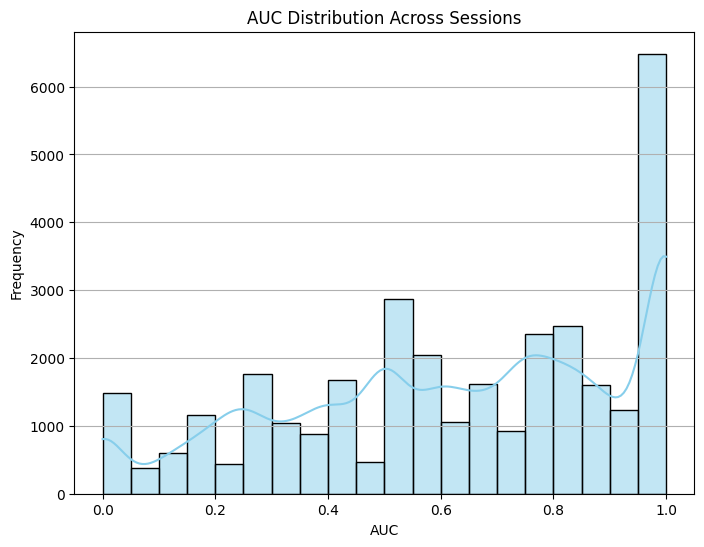

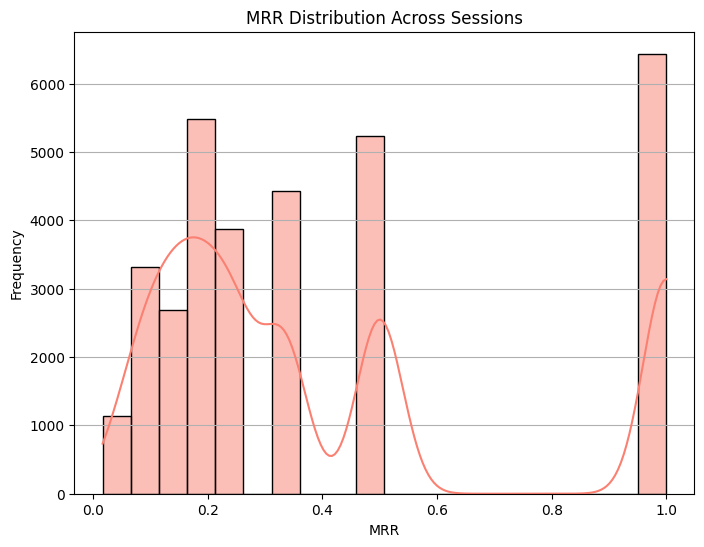

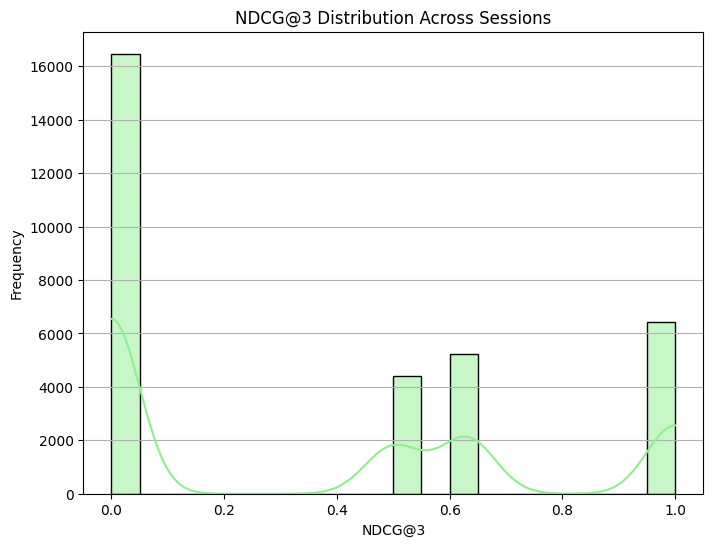

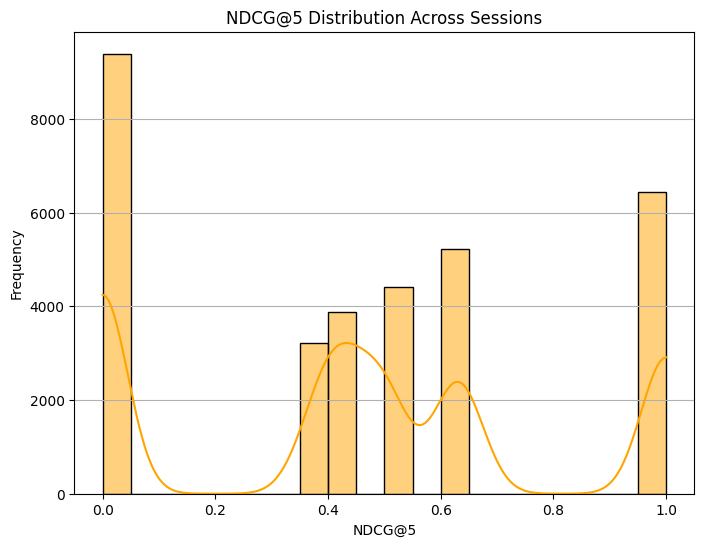

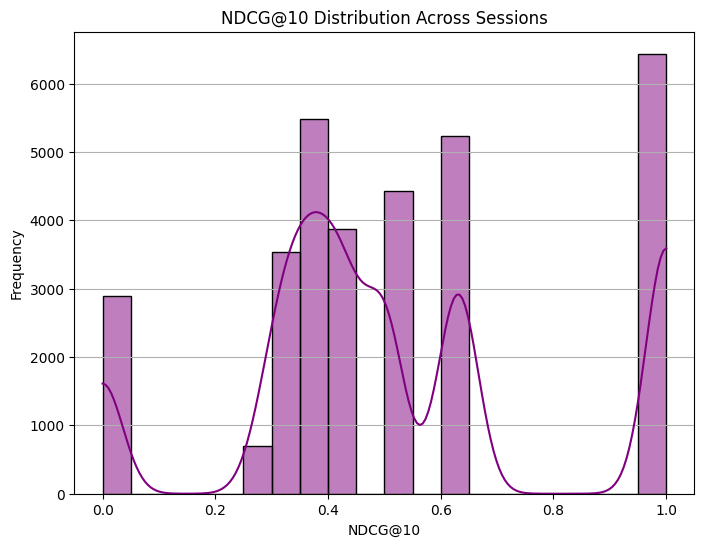

In [143]:
# plotting Results
def plot_metrics_distribution(results, metric, color, bins=20):
    """Plot the distribution of a metric."""
    plt.figure(figsize=(8, 6))
    sns.histplot(results[metric].dropna(), kde=True, color=color, bins=bins)
    plt.title(f"{metric} Distribution Across Sessions")
    plt.xlabel(metric)
    plt.ylabel("Frequency")
    plt.grid(axis='y')
    plt.show()

# plot Distributions
metrics_to_plot = {
    'AUC': 'skyblue',
    'MRR': 'salmon',
    'NDCG@3': 'lightgreen',
    'NDCG@5': 'orange',
    'NDCG@10': 'purple'
}

for metric, color in metrics_to_plot.items():
    plot_metrics_distribution(results, metric, color)